# Analysis

## Set up

In [1]:
import json
import random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data preparation

In [2]:
# load the data
data_path = 'data/merged_data/merged_data.csv'
data = pd.read_csv(data_path, header=0)

print(data.columns.tolist())
print(data.shape)

['Country Name', 'ISO3', 'Region', 'CPI Score 2023', 'CPI Score 2022', 'CPI Score 2021', 'CPI Score 2020', 'CPI Score 2019', 'CPI Score 2018', 'CPI Score 2017', 'CPI Score 2016', 'CPI Score 2015', 'CPI Score 2014', 'CPI Score 2013', 'CPI Score 2012', 'Rank 2023', 'Rank 2022', 'Rank 2021', 'Rank 2020', 'Rank 2019', 'Rank 2018', 'Rank 2017', 'WGI Indicator Name', 'WGI Indicator Code', '2022', '2021', '2020', '2019', '2018', '2017', '2016', '2015', '2014', '2013', '2012']
(5724, 35)


In [3]:
# subset the data to only include the indicators containing ': Estimate'
data = data[data['WGI Indicator Name'].str.contains(': Estimate')]
print(data.shape)

indicators = data['WGI Indicator Name'].unique()
print(indicators)

(954, 35)
['Control of Corruption: Estimate' 'Government Effectiveness: Estimate'
 'Political Stability and Absence of Violence/Terrorism: Estimate'
 'Regulatory Quality: Estimate' 'Rule of Law: Estimate'
 'Voice and Accountability: Estimate']


In [4]:
# TODO: maybe don't subset just yet?
# subset to the 20% most corrupt countries according to the Corruption Perception Index ranking in 2023
num_countries = int(0.2 * len(data['Country Name'].unique()))
subset = data[['Country Name', 'Rank 2023']].drop_duplicates().sort_values(by='Rank 2023', ascending=False).head(num_countries)
corrupt_countries = list(subset['Country Name'])
corrupt_countries
# data = data[data['Country / Territory'].isin(corrupt_countries)]
# data.head()

['Somalia',
 'South Sudan',
 'Nicaragua',
 'Equatorial Guinea',
 'Haiti',
 'Turkmenistan',
 'Libya',
 'Afghanistan',
 'Tajikistan',
 'Sudan',
 'Chad',
 'Myanmar',
 'Burundi',
 'Comoros',
 'Eritrea',
 'Cambodia',
 'Guatemala',
 'Honduras',
 'Iraq',
 'Azerbaijan',
 'Central African Republic',
 'Lebanon',
 'Zimbabwe',
 'Bangladesh',
 'Liberia',
 'Madagascar',
 'Mozambique',
 'Nigeria',
 'Guinea',
 'Uganda',
 'Cameroon']

In [5]:
def normalize_column(column):
    """Normalizes a column by subtracting the mean and dividing by the standard deviation."""
    mean = column.mean()
    std = column.std()
    return (column - mean) / std

In [6]:
cpi_score_cols = data.columns[data.columns.str.contains('CPI Score')]

# apply normalization to each CPI column
for col in cpi_score_cols:
    data[col] = normalize_column(data[col])

## Model construction

In [7]:
# define the players (countries)
players = data['Country Name'].unique().tolist()

# define strategies: Corrupt (C) and Non-Corrupt (NC)
strategies = ['C', 'NC']

# define payoffs
# for PoC, we define some hypothetical payoffs. These should ideally be derived from data.
#          Payoff matrix:
#          --------------------------------
#               |    C       | NC       |
#          --------------------------------
#           C   | (b-c, b-c) | (b, 0)   |
#           NC  | (0, b)     | (d, d)   |

b = random.randint(1, 10)   # benefit from corrupt strategy
c = random.randint(1, 10)   # cost of corrupt strategy
d = random.randint(1, 10)   # benefit from non-corrupt strategy

payoff_matrix = {
    ('C', 'C'): (b-c, b-c),
    ('C', 'NC'): (b, 0),
    ('NC', 'C'): (0, b),
    ('NC', 'NC'): (d, d)
}

In [8]:
# extract WGI indicators for 2022 and convert from long to wide format
indicators_data = data[['Country Name', 'WGI Indicator Name', '2022']].drop_duplicates()
indicators_data = indicators_data.pivot(index='Country Name', columns='WGI Indicator Name', values='2022')
indicators_data = indicators_data.reset_index()

print(f'Shape:\n'
      f'  Indicators dataset: {indicators_data.shape}\n'
      f'Columns:\n'
      f'  Indicators dataset: {indicators_data.columns}\n')

Shape:
  Indicators dataset: (159, 7)
Columns:
  Indicators dataset: Index(['Country Name', 'Control of Corruption: Estimate',
       'Government Effectiveness: Estimate',
       'Political Stability and Absence of Violence/Terrorism: Estimate',
       'Regulatory Quality: Estimate', 'Rule of Law: Estimate',
       'Voice and Accountability: Estimate'],
      dtype='object', name='WGI Indicator Name')



- For policies that increase penalties or enforce the rule of law, the indicator value is added to `c` to reflect increased costs of corruption.
- For policies that improve government services, enhance regulatory frameworks, or promote democratic participation, the indicator value is added to `d` to reflect increased benefits of non-corrupt behavior.
- For policies that strengthen political stability, the indicator value is added to `b` to reflect increased overall benefits in a stable political environment.

In [9]:
# define policy intervention to indicator mapping
policy_indicator_mapping = {
    'Increase Penalties': 'Control of Corruption: Estimate',
    'Improve Government Services': 'Government Effectiveness: Estimate',
    'Strengthen Political Stability': 'Political Stability and Absence of Violence/Terrorism: Estimate',
    'Enhance Regulatory Framework': 'Regulatory Quality: Estimate',
    'Enforce Rule of Law': 'Rule of Law: Estimate',
    'Promote Democratic Participation': 'Voice and Accountability: Estimate'
}

# define policy interventions and whether we add or subtract the indicator value
policy_interventions = [
    ('Increase Penalties', 'c'),                # increase penalties for corruption
    ('Improve Government Services', 'd'),       # improve government services
    ('Strengthen Political Stability', 'b'),    # reduce the benefit of corruption
    ('Enhance Regulatory Framework', 'd'),      # enhance regulatory quality
    ('Enforce Rule of Law', 'c'),               # enforce rule of law
    ('Promote Democratic Participation', 'd')   # promote democratic participation
]

## Policy simulation

In [10]:
def simulate_policy(policy, num_iterations=100):
    """Simulate the evolution of strategies over time given a policy intervention."""
    results = {}

    # initialize params
    b_new, c_new, d_new = b, c, d
    policy_name, param = policy
    column = policy_indicator_mapping[policy_name]

    for country in players:
        indicator_value = indicators_data[indicators_data['Country Name'] == country][column].values[0]
        if param == 'b':
            b_new += indicator_value
        elif param == 'c':
            c_new += indicator_value
        elif param == 'd':
            d_new += indicator_value
    
        new_payoff_matrix = {
            ('C', 'C'): (b_new-c_new, b_new-c_new),
            ('C', 'NC'): (b_new, 0),
            ('NC', 'C'): (0, b_new),
            ('NC', 'NC'): (d_new, d_new)
        }
        # random initial strategy distribution
        strategy_distribution = {'C': np.random.uniform(0, 1), 'NC': np.random.uniform(0, 1)}
        total_initial = strategy_distribution['C'] + strategy_distribution['NC']
        strategy_distribution = {k: v/total_initial for k, v in strategy_distribution.items()}        

        # simulate the evolution of strategies over time
        for _ in range(num_iterations):
            next_distribution = {'C': 0, 'NC': 0}
            for strategy in strategies:
                for opponent_strategy in strategies:
                    payoff = new_payoff_matrix[(strategy, opponent_strategy)]
                    next_distribution[strategy] += strategy_distribution[opponent_strategy] * payoff[strategy == 'NC']
            total = sum(next_distribution.values())
            if total == 0:
                next_distribution = {'C': 0.5, 'NC': 0.5}
            else:
                next_distribution = {k: v/total for k, v in next_distribution.items()}
            strategy_distribution = next_distribution
        results[country] = strategy_distribution
    
    return results

In [11]:
# define path for analysis results
results_path = Path('results')
results_path.mkdir(parents=True, exist_ok=True)

In [12]:
# apply each policy and store the results
simulation_results = {}
for policy_intervention in policy_interventions:
    simulation_results[policy_intervention[0]] = simulate_policy(policy_intervention)

# save the simulation results to a JSON file
simulation_results_path = f'{results_path}/simulation_results.json'
with open(simulation_results_path, 'w') as f:
    json.dump(simulation_results, f, indent=4)

## Validate results

In [13]:
def normalize_simulated_cpi(simulated_cpi, real_cpi_mean, real_cpi_std):
    """Normalize the simulated CPI scores based on the real-world data."""
    return (simulated_cpi - real_cpi_mean) / real_cpi_std

In [14]:
def validate_results(simulation_results, val_scores):
    """Validate the simulation results against real-world data."""
    validation_results = {}

    # compute the mean and standard deviation of the real CPI scores
    real_cpi_mean = val_scores['CPI Score 2023'].mean()
    real_cpi_std = val_scores['CPI Score 2023'].std()

    for policy_name, results in simulation_results.items():
        correlation = {}
        for country, distribution in results.items():
            if country in val_scores.index:
                real_cpi = val_scores.loc[country, 'CPI Score 2023']
                simulated_cpi = distribution['NC']  # assuming NC strategy correlates with higher CPI scores
                normalized_simulated_cpi = normalize_simulated_cpi(simulated_cpi, real_cpi_mean, real_cpi_std)
                correlation[country] = (real_cpi, normalized_simulated_cpi)
        
        validation_results[policy_name] = correlation
    return validation_results

In [15]:
# extract real-world data (CPI scores) for validation
val_scores = data[['Country Name', 'CPI Score 2023']].drop_duplicates().set_index('Country Name')
validation_results = validate_results(simulation_results, val_scores=val_scores)

# calculate statistical measures (e.g., correlation coefficient) for validation
print(f'Correlation coefficient for different policy interventions:')
for policy_name, correlations in validation_results.items():
    real_cpis, normalized_simulated_cpis = zip(*correlations.values())
    correlation_coefficient = np.corrcoef(real_cpis, normalized_simulated_cpis)[0, 1]
    print(f'  {policy_name}: {correlation_coefficient}')

Correlation coefficient for different policy interventions:
  Increase Penalties: 0.1270642688118855
  Improve Government Services: 0.03646323643336528
  Strengthen Political Stability: -0.05490906009339607
  Enhance Regulatory Framework: 0.07566302232162703
  Enforce Rule of Law: 0.12642153258928884
  Promote Democratic Participation: -0.05264175954259789


## Visualization

In [16]:
path_to_figs = Path('results', 'plots')
path_to_figs.mkdir(parents=True, exist_ok=True)

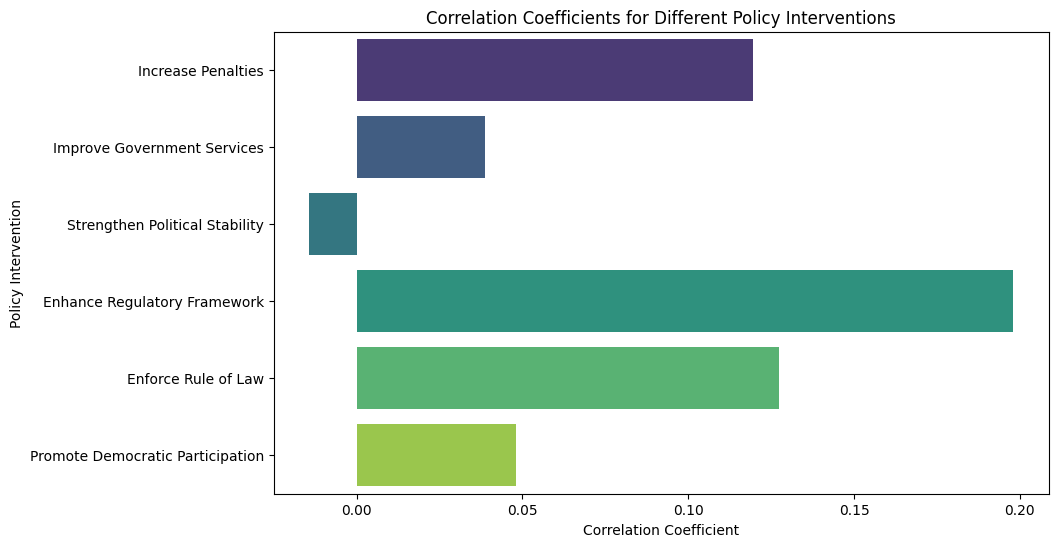

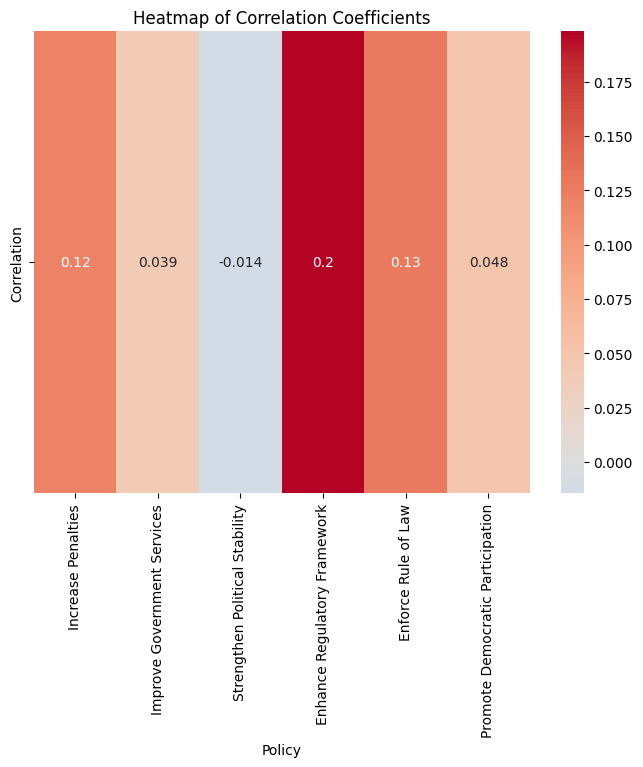

In [17]:
# Example data for visualization
correlation_data = {
    'Increase Penalties': 0.1194650558539891,
    'Improve Government Services': 0.03871325868745889,
    'Strengthen Political Stability': -0.014465257093015941,
    'Enhance Regulatory Framework': 0.1980362587393781,
    'Enforce Rule of Law': 0.1274272886284593,
    'Promote Democratic Participation': 0.04806013446498635
}

# Convert to DataFrame for easier plotting
correlation_df = pd.DataFrame(list(correlation_data.items()), columns=['Policy', 'Correlation'])

# Bar Chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Correlation', y='Policy', hue='Policy', data=correlation_df, palette='viridis', legend=False)
plt.title('Correlation Coefficients for Different Policy Interventions')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Policy Intervention')
plt.savefig(f'{path_to_figs}/correlation_bar_plot.png')
plt.show()

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_df.set_index('Policy').T, annot=True, cmap='coolwarm', center=0)
plt.title('Heatmap of Correlation Coefficients')
plt.savefig(f'{path_to_figs}/correlation_heat_map.png')
plt.show()